In [42]:
import numpy as np
import matplotlib.pyplot as plt

import tiles3 as tc
import gymnasium as gym

from joblib import Parallel, delayed

from tqdm import tqdm

In [81]:
class TileCoder:

    def __init__(self, iht_size, num_tiles, num_tilings):
        self.iht = tc.IHT(iht_size)
        self.num_tiles = num_tiles
        self.num_tilings = num_tilings

    def get_tiles(self, obs):
        position, velocity = obs
        position *= self.num_tiles / 1.8
        velocity *= self.num_tiles / 0.14
        tiles = tc.tiles(self.iht, self.num_tilings, [position, velocity])
        return np.array(tiles)

In [82]:
class SarsaAgent:

    def __init__(self, num_actions, tilecoder):
        self.num_actions = num_actions
        self.tilecoder = tilecoder
        self.iht_size = tilecoder.iht.size
        self.epsilon = None
        self.gamma = None
        self.alpha = None
        self.w = np.zeros([self.num_actions, self.iht_size])
        self.last_action = None
        self.last_tiles = None

    def select_action(self, tiles):
        if np.random.random() > self.epsilon:
            action_values = self.w[:, tiles].sum(axis=1)
            action = action_values.argmax()
        else:
            action = np.random.choice(self.num_actions)
        return action
    
    def start(self, state):
        tiles = self.tilecoder.get_tiles(state)
        action = self.select_action(tiles)
        self.last_action = action
        self.last_tiles = tiles.copy()
        return self.last_action
    
    def step(self, state, reward):
        tiles = self.tilecoder.get_tiles(state)
        action = self.select_action(tiles)

        last_value = self.w[self.last_action][self.last_tiles].sum()
        current_value = self.w[action][tiles].sum()
        delta = reward + self.gamma * current_value - last_value
        self.w[self.last_action][self.last_tiles] += self.alpha * delta

        self.last_action = action
        self.last_tiles = tiles.copy()
        return self.last_action
    
    def end(self, reward):
        last_value = self.w[self.last_action][self.last_tiles].sum()
        delta = reward - last_value
        self.w[self.last_action][self.last_tiles] += self.alpha * delta

In [83]:
env = gym.make('MountainCar-v0', max_episode_steps=1000)

def run():
    tilecoder = TileCoder(iht_size=4096, num_tiles=8, num_tilings=8)
    agent = SarsaAgent(num_actions=3, tilecoder=tilecoder)
    agent.epsilon = 0.1
    agent.alpha = 0.5 / tilecoder.num_tilings
    agent.gamma = 1.0
    n_episodes = 500
    nsteps_list = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        action = agent.start(obs)
        nsteps = 0
        while True:
            obs, reward, done, over, _ = env.step(action)
            action = agent.step(obs, reward)
            nsteps += 1
            if done or over:
                agent.end(reward)
                break
        nsteps_list.append(nsteps)
    return nsteps_list

n_runs = 100
results = Parallel(n_jobs=-1)(delayed(run)() for _ in tqdm(range(n_runs)))

100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


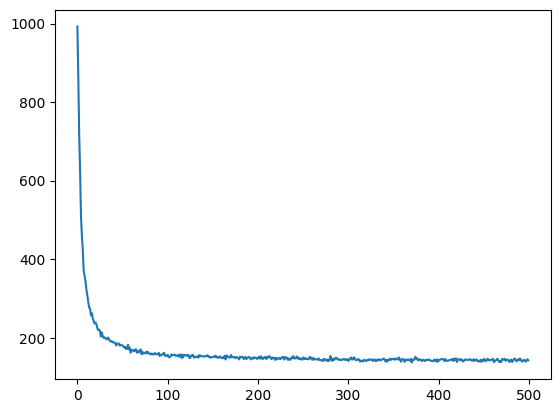

In [80]:
plt.plot(np.mean(results, axis=0))
plt.show()